In [1]:
# pip install livelossplot

In [2]:

import os
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from tqdm import tqdm # for progress bar
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Libraries for TensorFlow
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from tensorflow.keras.optimizers import Adam
from keras import callbacks
# from livelossplot.inputs.keras import PlotLossesCallback

# Library for Transfer Learning
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

In [3]:
# Load data
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)

# Split validate set, training set, and test set
x_val = x_train[-2000:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:]
y_train = y_train[:-2000]

2023-05-08 22:27:30.617377: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 22:27:31.420150: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2631 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:e3:00.0, compute capability: 8.6


In [4]:
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
for layer in base_model.layers:
  layer.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [5]:
# Reducing the dropout rate from 0.5 to 0.2 yields a better result
x = layers.Flatten()(base_model.output)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# The combination of the base model and added layers is name head_model 
output_layer = layers.Dense(10, activation = 'softmax')(x)
head_model = Model(inputs = base_model.input, outputs = output_layer)
head_model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
head_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [6]:
# Incorporating reduced learning and early stopping for callback
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

# plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = callbacks.ModelCheckpoint(filepath='model/vgg16_mnist.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

callbacks_def = [reduce_learning, eary_stopping, tl_checkpoint_1]

In [7]:
# Record start time
start_time = time.time()
print('Training started at %s', time.ctime(start_time))

# Train model
history = head_model.fit(x_train, y_train, batch_size=64, epochs=40, validation_data=(x_val, y_val), callbacks=callbacks_def)

# Record end time
end_time = time.time()
print('Training ended at %s', time.ctime(end_time))

# Calculate duration of training
duration = end_time - start_time
print('Training duration: %i seconds', int(duration))

Training started at %s Mon May  8 22:27:32 2023
Epoch 1/40


2023-05-08 22:27:35.637857: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2023-05-08 22:27:37.807191: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 22:27:37.808991: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 22:27:37.809054: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-08 22:27:37.810187: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 22:27:37.810276: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


 11/907 [..............................] - ETA: 9s - loss: 2.7084 - accuracy: 0.2898    

2023-05-08 22:27:38.347858: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-08 22:27:38.348020: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-08 22:27:38.403630: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-05-08 22:27:38.403783: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

907/907 [==============================] - ETA: 0s - loss: 0.3278 - accuracy: 0.8938
Epoch 1: val_loss improved from inf to 0.11601, saving model to model/vgg16_mnist.weights.best.hdf5
907/907 [==============================] - 16s 12ms/step - loss: 0.3278 - accuracy: 0.8938 - val_loss: 0.1160 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 2/40
902/907 [============================>.] - ETA: 0s - loss: 0.1791 - accuracy: 0.9422
Epoch 2: val_loss improved from 0.11601 to 0.10511, saving model to model/vgg16_mnist.weights.best.hdf5
907/907 [==============================] - 9s 10ms/step - loss: 0.1790 - accuracy: 0.9422 - val_loss: 0.1051 - val_accuracy: 0.9670 - lr: 0.0010
Epoch 3/40
906/907 [============================>.] - ETA: 0s - loss: 0.1566 - accuracy: 0.9477
Epoch 3: val_loss did not improve from 0.10511
907/907 [==============================] - 8s 9ms/step - loss: 0.1565 - accuracy: 0.9477 - val_loss: 0.1215 - val_accuracy: 0.9590 - lr: 0.0010
Epoch 4/40
907/907 [=================

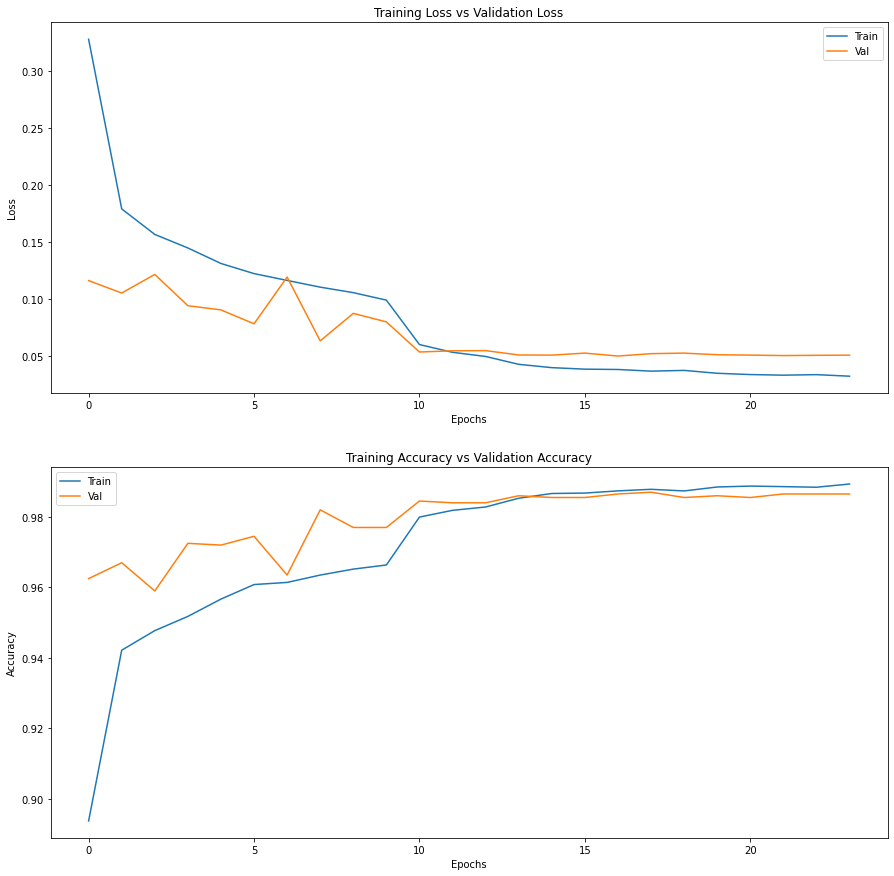

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [9]:
head_model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.0680 - accuracy: 0.9791


[0.06801296770572662, 0.9790999889373779]

In [10]:
vgg_preds = head_model.predict(x_test)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [11]:
models.save_model(head_model, 'model/vgg16_mnist')
# # Load the model
# model = models.load_model('model/vgg16_mnist')

2023-05-08 22:31:03.559904: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/vgg16_mnist/assets


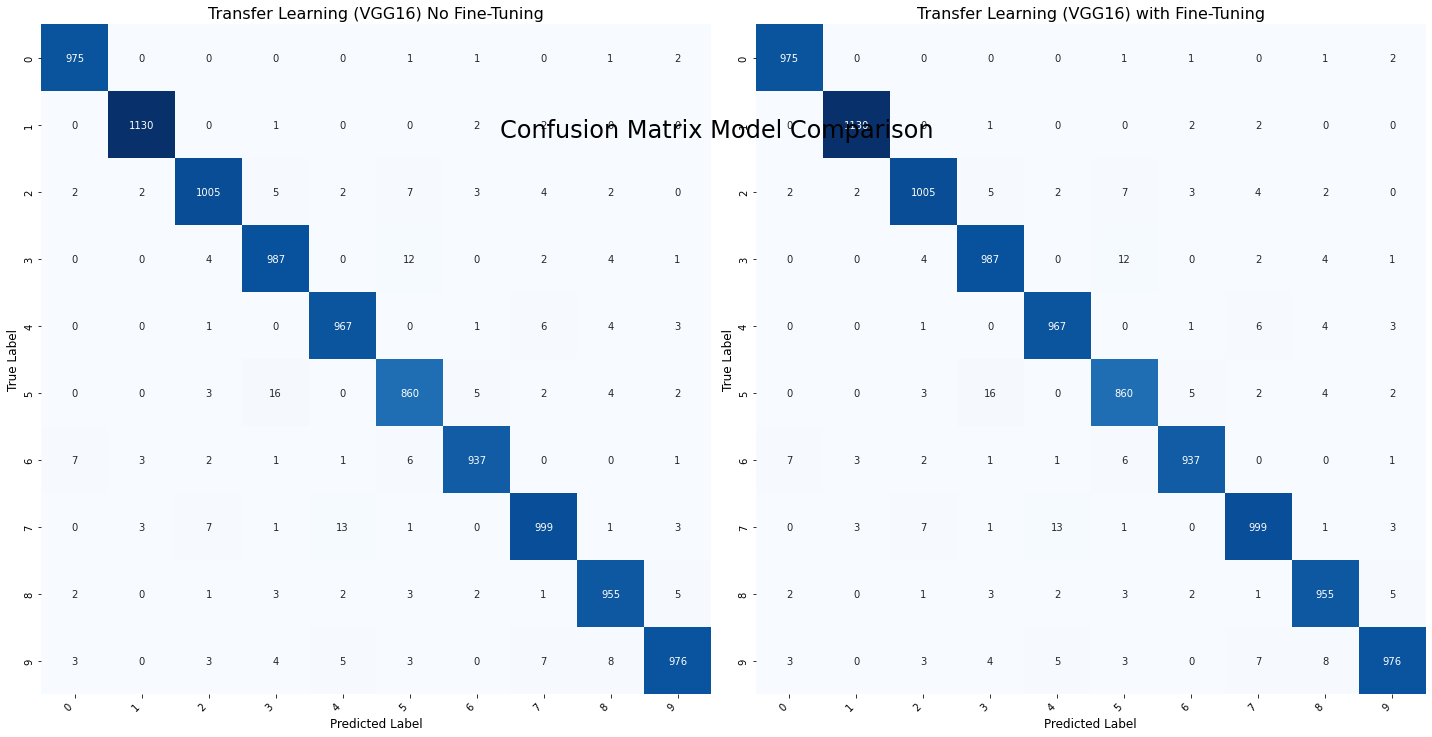

In [12]:
# Get the names of the ten classes
class_names = [0,1,2,3,4,5,6,7,8,9]

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(20, 10))

plot_heatmap(y_test, vgg_pred_classes, class_names, ax1, title="Transfer Learning (VGG16) No Fine-Tuning")    
plot_heatmap(y_test, vgg_pred_classes, class_names, ax2, title="Transfer Learning (VGG16) with Fine-Tuning")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()